## Sensitivity of the theoretical formula on the power spectral density values

Introduction: In the directory below one can find the script we use to compute the power spectral density (PSD) at the betatron tune of the noise signal for our simulations. 

https://github.com/natriant/utils/tree/master/noise_studies_playground/PSD_computation

Issue: However, to obtain representative values of the power spectral density we should use the average of 1000 or more $\mid Y_k \mid ^2$.

Mehtodology: With this script we study the sensitivity of the theoretical formula on the power spectral density values. Specifically we compute the power spctral density of the noise signal taking into account only one $\mid Y_k \mid ^2$.


In [66]:
import numpy as np
import matplotlib.pyplot as plt

#### Functions to create the noise and compute the PSD

In [67]:
def create_noise(N, colored=False):        
    if colored: # A.Wolski's method
        phi_0 = 1e-8  # amplitude of noise, aka stdPhaseNoise 
        Delta_psi = 0.18 # the peak of the spectrum

        psi_t_list = []
        psi_t = 0

        # parameters for ksi
        mean = 0.0
        std = 0.06
        for i in range(N):
            psi_t_list.append(psi_t)
            ksi = np.random.normal(mean, std)  # different seed on each turn
            psi_t = psi_t + 2 * np.pi * Delta_psi + 2 * np.pi * ksi

        # Construct the noise signal
        y = phi_0 * np.cos(psi_t_list)
        
    else:
        mu, stdPhaseNoise = 0, 1e-8
        y = np.random.normal(mu, stdPhaseNoise, N)
    
    return y

In [68]:
def compute_PSD(N, frev, noise_flag, n_ffts):
    time = np.arange(N)/frev # convert from turns to time
    Dt = time[1]-time[0] # sampling (s)
    freq = np.linspace(0, N/time[-1], N)
    Df = freq[1]-freq[0]
   
    #### To obtain a more precise value of PSD, we use the average of 10000 FFTs
    fft_list = []
    for j in range(n_ffts):#(1000):
        y_noise = create_noise(N, noise_flag)
        fft = np.fft.fft(y_noise)
        fft_list.append(fft)
        
    mean_dft = np.mean(np.abs(fft_list)**2, axis=0)
    PSD = mean_dft/(Df*N**2) # power spectral density
    
    
    # compute the PSD at the frequency of interest. 
    # In our case in the betatron frequency, vb. 
    # find the closest value to the vb at the frequency list
    vb = 0.18
    closest_to_vb = freq[min(range(len(freq)), key=lambda i: abs(freq[i] - vb*frev))] # Hz
    PSD_vb_index = [i for i in range(len(freq)) if freq[i] == closest_to_vb]
    PSD_vb = PSD[PSD_vb_index] # rad^2/Hz or V^2/Hz
    
    
    return PSD, freq, PSD_vb

#### Functions to compute the theoretical emittance growth rate

In [69]:
def emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, PSD_phi):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaPhi*PSD_phi
    return 2*ey_rate #2*ey_rate

In [70]:
def emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A):
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaA*PSD_A
    return 4*ey_rate

### SPS parameters

In [71]:
betay = 76 # m
# Beam parameters
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
CDeltaPhi = 0.52 # approx
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
beta_0 = 0.999999
gamma_0 = 287.7
CDeltaA = 0.24 # approx

## A) Random error

### Define the parameters of the noise signal

In [72]:
N = 1000 # length of the signal
frev = 43.45e3 # the revolution frequency of SPS
noise_flag = False # False for white noise, True for colroed noise
n_ffts = 1 # Number of FFT spectrum averaged to obtain the PSD

#### Mulitple trials of PSD computing 

In [73]:
PSD_vb_list = []
emit_list = []
for i in range(1000): # Number of trials
    PSD, freq, PSD_vb = compute_PSD(N, frev, noise_flag, n_ffts)
    PSD_vb_list.append(PSD_vb)
    
    # compute emittance growth rate
    ey_geom_rate_phi = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, PSD_vb*(scale_factor)**2)
    ey_norm_rate_phi = ey_geom_rate_phi*beta_0*gamma_0
    emit_list.append(ey_norm_rate_phi*1e9)

In [85]:
print(np.min(PSD_vb_list)*scale_factor**2)
print(np.max(PSD_vb_list)*scale_factor**2)

2.0377733466282916e-13
1.2089474862829606e-09


In [74]:
params = {'legend.fontsize': 16,
          'axes.labelsize': 17,
          'xtick.labelsize': 17,
          'ytick.labelsize': 17}

plt.rc('text', usetex=False)
plt.rcParams.update(params)

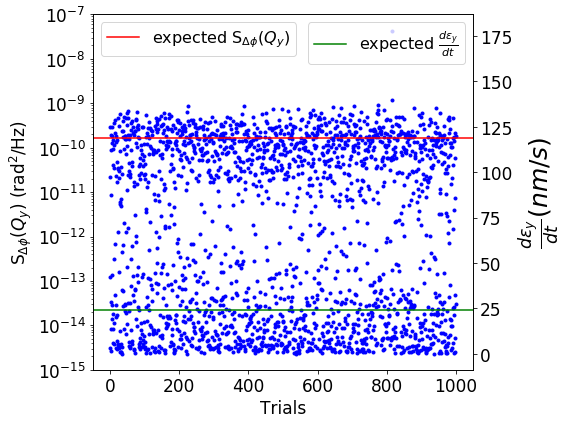

In [82]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

# automatically update ylim of ax2 when ylim of ax1 changes.
ax1.plot(np.array(PSD_vb_list)*(scale_factor)**2, '.', c='b')
ax2.plot(emit_list, '.', c ='b')


ax1.axhline(2.3e-21*(scale_factor)**2, c='r', label='expected '+'S'+ r'$_{\Delta \phi}(Q_y)$')
ax2.axhline(24, c='g', label='expected '+r'$\frac{d\epsilon _y}{dt} $')

ax1.set_ylim(1e-15, 1e-7)
ax1.set_yscale('log')

# Axis labels
ax1.set_ylabel('S'+ r'$_{\Delta \phi}(Q_y)$'+ ' (rad'+r'$^2$'+'/Hz)', fontsize=17)
ax1.set_xlabel('Trials')

ax2.set_ylabel(r'$\frac{d\epsilon _y}{dt} $' + r'$ (nm/s )$', fontsize=25)


ax1.legend(loc=2)
ax2.legend(loc=1)
plt.tight_layout()
#plt.savefig('PSD_1FFT_many_trials.png')

#### Histogram of PSD values

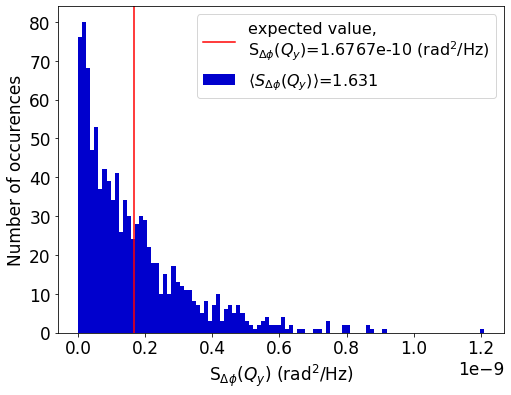

In [83]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.hist(np.array(PSD_vb_list)*scale_factor**2, bins=100, color='mediumblue', label=r'$\langle S$'+ r'$_{\Delta \phi}(Q_y) \rangle $'+ '={:.3f}'.format(np.mean(PSD_vb_list)*scale_factor**2*1e10))
ax1.axvline(2.3e-21*scale_factor**2, c='r', label='expected value, \n'+'S'+ r'$_{\Delta \phi}(Q_y) $'+ '={}'.format(2.3e-21*scale_factor**2)+ ' (rad'+r'$^2$'+'/Hz)')
ax1.set_xlabel('S'+ r'$_{\Delta \phi}(Q_y)$'+ ' (rad'+r'$^2$'+'/Hz)', fontsize=17)
ax1.set_ylabel('Number of occurences')
ax1.legend()
#ax.set_xscale('log')
#plt.savefig('hist_PSD_1000_trials_xlog.png')

#### Histogram of emittance growth values

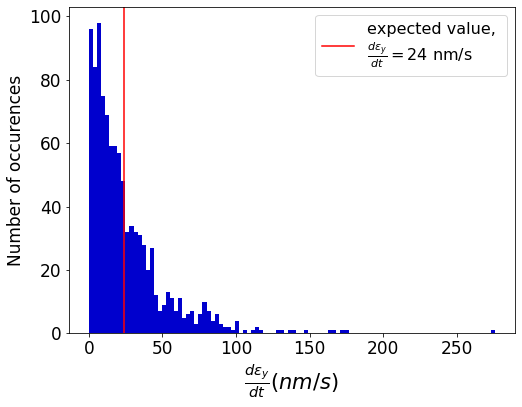

In [14]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.hist(np.array(emit_list), bins=100, color='mediumblue')
ax1.axvline(24, c='r', label='expected value, \n'+r'$\frac{d\epsilon _y}{dt} = $' +'{} nm/s'.format(24))
ax1.set_xlabel(r'$\frac{d\epsilon _y}{dt} $' + r'$ (nm/s )$', fontsize=21)
ax1.set_ylabel('Number of occurences')
ax1.legend()
#plt.savefig('hist_dey_1000_trials.png')

#### Secondary horizontal axis

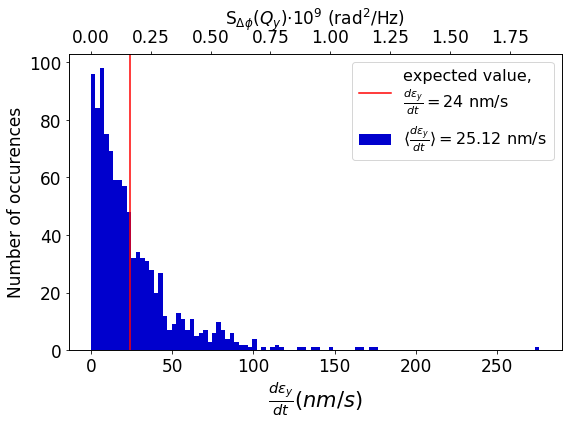

In [15]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()


ax1.hist(np.array(emit_list), bins=100, color='mediumblue', label=r'$\langle \frac{d\epsilon _y}{dt} \rangle = $' +'{:.2f} nm/s'.format(np.mean(emit_list)))
ax1.axvline(24, c='r', label='expected value, \n'+r'$\frac{d\epsilon _y}{dt} = $' +'{} nm/s'.format(24))
ax1.set_xlabel(r'$\frac{d\epsilon _y}{dt} $' + r'$ (nm/s )$', fontsize=21)
ax1.set_ylabel('Number of occurences')
ax1.legend()

ax2.hist(np.array(PSD_vb_list)*scale_factor**2*1e9, bins=100, alpha =0.01, color='mediumblue')
ax2.set_xlabel('S'+ r'$_{\Delta \phi}(Q_y)$'+ r'$\cdot 10^9$'+ ' (rad'+r'$^2$'+'/Hz)', fontsize=17)

plt.tight_layout()
#plt.savefig('hist_dey_1000_trials_2ndHorizontalAxis_v2.png')

#### Reduction of the random error by averaging multiples FFT spectrums of the noise signals for the PSD computation

In [39]:
PSD_vb_list = []
for i in range(1, 1000):
    n_ffts = int(i)
    PSD, freq, PSD_vb = compute_PSD(N, frev, noise_flag, n_ffts)
    PSD_vb_list.append(PSD_vb)

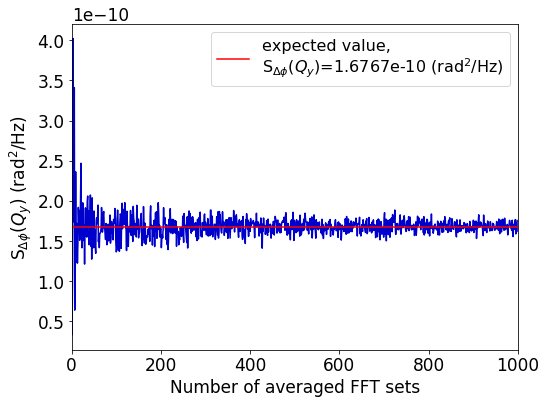

In [62]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(np.array(PSD_vb_list)*scale_factor**2, '-', color='mediumblue')

ax1.set_xlabel('Number of averaged FFT sets')
ax1.set_ylabel('S'+ r'$_{\Delta \phi}(Q_y)$'+ ' (rad'+r'$^2$'+'/Hz)', fontsize=17)

ax1.axhline(2.3e-21*scale_factor**2, c='r', label='expected value, \n'+'S'+ r'$_{\Delta \phi}(Q_y) $'+ '={}'.format(2.3e-21*scale_factor**2)+ ' (rad'+r'$^2$'+'/Hz)')
ax1.set_xlim(0, 1000)

plt.legend()
#plt.savefig('average_of_FFT_spectrums.png')